<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_week5_manufacturing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KNN Accuracy: 0.67
Random Forest Accuracy: 0.865

- KNN can overfit with small neighbor counts.
- Random Forest controls variance by ensemble learning.
- Balance bias and variance for generalization.

Random Forest KFold CV Accuracy: 0.9071973244147158
KNN LOO CV Accuracy (subset): 0.66
Random Forest StratifiedKFold CV Accuracy: 0.8972151616499444
Best Parameters from Grid Search: {'max_features': 3, 'n_estimators': 50}
Final Model Accuracy after Grid Search: 0.865


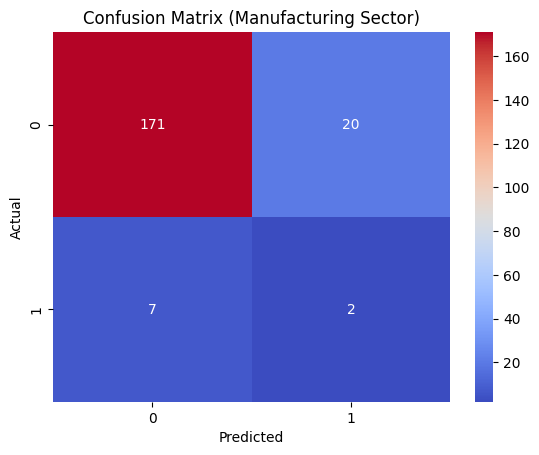

In [1]:
# 0. Import Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Generate a Realistic Manufacturing Dataset
np.random.seed(42)
machines = ['Machine_' + str(i) for i in range(1, 21)]  # 20 machines
data = []

for date in pd.date_range(start='2023-01-01', periods=1000):
    machine_id = np.random.choice(machines)
    temperature = np.random.normal(70, 10)  # degrees Fahrenheit
    vibration = np.random.normal(5, 1.5)    # vibration intensity
    pressure = np.random.normal(100, 15)    # psi
    age = np.random.randint(0, 20)           # years
    maintenance = np.random.binomial(1, 0.3) # maintenance done in last month?
    fail = np.random.binomial(1, 0.05 + 0.02 * (temperature > 80) + 0.02 * (vibration > 6))  # Fail more likely if high temp or vib
    data.append([date, machine_id, temperature, vibration, pressure, age, maintenance, fail])

machines_df = pd.DataFrame(data, columns=['Date', 'MachineID', 'Temperature', 'Vibration', 'Pressure', 'Age', 'Maintenance', 'Fail'])
machines_df.sort_values('Date', inplace=True)

# 2. Create Rolling Features
machines_df['AvgTemp5'] = machines_df.groupby('MachineID')['Temperature'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
machines_df['AvgVib5'] = machines_df.groupby('MachineID')['Vibration'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean())

# 3. Feature and Label Selection
features = machines_df[['Temperature', 'Vibration', 'Pressure', 'Age', 'Maintenance', 'AvgTemp5', 'AvgVib5']]
labels = machines_df['Fail']

# Fill NaN values from rolling
features = features.fillna(0)

# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# 5. SMOTE Oversampling (to balance the training set)
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# 6. Class Weights
class_weights = dict(zip(np.unique(y_train_resampled), compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)))

# 7. Models
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_resampled, y_train_resampled)
knn_preds = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_preds))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_features=3, random_state=42, class_weight=class_weights)
rf.fit(X_train_resampled, y_train_resampled)
rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

# 8. Bias-Variance Tradeoff
print("""
- KNN can overfit with small neighbor counts.
- Random Forest controls variance by ensemble learning.
- Balance bias and variance for generalization.
""")

# 9. Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=kfold)
print("Random Forest KFold CV Accuracy:", np.mean(rf_cv_scores))

loo = LeaveOneOut()
small_features = X_train_resampled.sample(50, random_state=42)
small_labels = y_train_resampled.loc[small_features.index]
loo_scores = cross_val_score(knn, small_features, small_labels, cv=loo)
print("KNN LOO CV Accuracy (subset):", np.mean(loo_scores))

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=skfold)
print("Random Forest StratifiedKFold CV Accuracy:", np.mean(stratified_scores))

# 10. Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': [2, 3, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight=class_weights), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters from Grid Search:", grid_search.best_params_)
final_model = grid_search.best_estimator_
final_preds = final_model.predict(X_test)
print("Final Model Accuracy after Grid Search:", accuracy_score(y_test, final_preds))

# 11. Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title('Confusion Matrix (Manufacturing Sector)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()